#Imports,reading data and checking correlation

##importing libraries, reading data

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
#change directory and show files in it 
import os
os.chdir("/content/drive/MyDrive/data for project ca683")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('accidents.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,2,15,16,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df=df[df['accident_year']>2009]

## checking correlation between features and Accident severity (label)

In [2851]:
corr = df.corr()['accident_severity']

In [2852]:
corr[corr.values>.01]

location_easting_osgr                          0.034544
longitude                                      0.034701
accident_severity                              1.000000
number_of_vehicles                             0.072435
junction_detail                                0.033127
junction_control                               0.066518
second_road_class                              0.059219
second_road_number                             0.018898
pedestrian_crossing_human_control              0.025103
pedestrian_crossing_physical_facilities        0.022361
weather_conditions                             0.020590
road_surface_conditions                        0.012486
special_conditions_at_site                     0.010297
did_police_officer_attend_scene_of_accident    0.106049
trunk_road_flag                                0.030550
Name: accident_severity, dtype: float64

In [2853]:
corr[corr.values<-.03]

accident_year              -0.055737
location_northing_osgr     -0.038916
latitude                   -0.038931
police_force               -0.051028
number_of_casualties       -0.065578
local_authority_district   -0.054025
road_type                  -0.036812
speed_limit                -0.082391
light_conditions           -0.052661
urban_or_rural_area        -0.088359
Name: accident_severity, dtype: float64

In [2854]:
df.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')

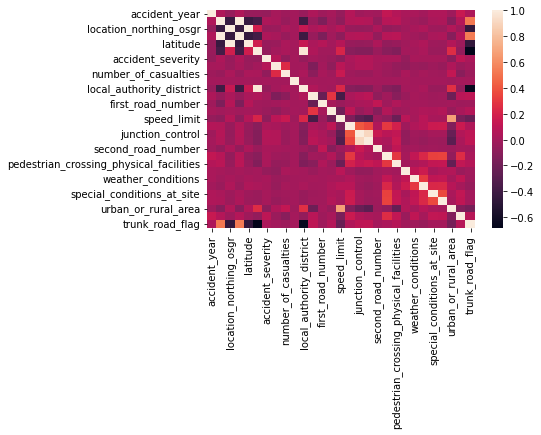

In [2855]:
sns.heatmap(df.corr())

#DNN Iteration 1 - Features: 'weather_conditions','speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['weather_conditions', 'speed_limit', 'accident_severity']]

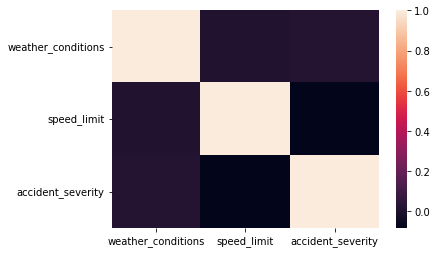

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

weather_conditions   -1.0
speed_limit          -1.0
accident_severity     1.0
dtype: float64

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['weather_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=0]
df_features = df_features[df_features['speed_limit']!=-1]

In [ ]:
#bucketising weather condtion into 2 bins
df_features['weather_conditions'] = df_features['weather_conditions'].replace(1,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(4,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(5,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(7,0)
df_features['weather_conditions']= df_features['weather_conditions'].replace(2,1)
df_features['weather_conditions']= df_features['weather_conditions'].replace(3,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(6,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(8,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(9,1)

In [ ]:
df_features['weather_conditions'].unique()

array([1, 0])

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1225494
2     230660
1      18134
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18134
class 0 (non-fatal): 1456154


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18134
class 0 (non-fatal): 18134


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='weather_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe6gz2waf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpe6gz2waf/model.ckpt-5000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpe6gz2waf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 0.66826135, step = 5000
INFO:tensorflow:global_step/sec: 274.428
INFO:tensorflow:loss = 0.6725922, step = 5100 (0.368 sec)
INFO:tensorflow:global_step/sec: 355.6
INFO:tensorflow:loss = 0.67754954, step = 5200 (0.281 sec)
INFO:tensorflow:global_step/sec: 340.594
INFO:tensorflow:loss = 0.65349394, step = 5300 (0.295 sec)
INFO:tensorflow:global_step/sec: 320.683


###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T14:10:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpe6gz2waf/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.73269s
INFO:tensorflow:Finished evaluation at 2022-04-08-14:10:34
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.66317415, accuracy_baseline = 0.50104773, auc = 0.67607296, auc_precision_recall = 0.6433748, average_loss = 0.6601647, global_step = 10000, label/mean = 0.50104773, loss = 0.65972394, precision = 0.6687061, prediction/mean = 0.5383084, recall = 0.64957076
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpe6gz2waf/model.ckpt-10000

Test set accuracy: 0.663



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpe6gz2waf/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
a=df_predictions[df_predictions['actual label']==1]
a

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
2,[-0.07688499],[0.48078823],"[0.51921177, 0.4807882]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
4,[0.11005997],[0.5274872],"[0.47251275, 0.5274873]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
5,[-0.07688499],[0.48078823],"[0.51921177, 0.4807882]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
7,[0.28512645],[0.57080257],"[0.42919737, 0.57080257]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
9,[-0.07688499],[0.48078823],"[0.51921177, 0.4807882]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
...,...,...,...,...,...,...,...,...,...,...
9060,[-0.07688499],[0.48078823],"[0.51921177, 0.4807882]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
9062,[0.47207093],[0.61587375],"[0.38412622, 0.6158738]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
9063,[-0.07688499],[0.48078823],"[0.51921177, 0.4807882]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
9065,[0.47207093],[0.61587375],"[0.38412622, 0.6158738]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6740039621395554 
Accuracy of label 1 (fatal):  0.6522988505747126


Text(0.5, 1.0, 'percentage accuracy for each class/label')

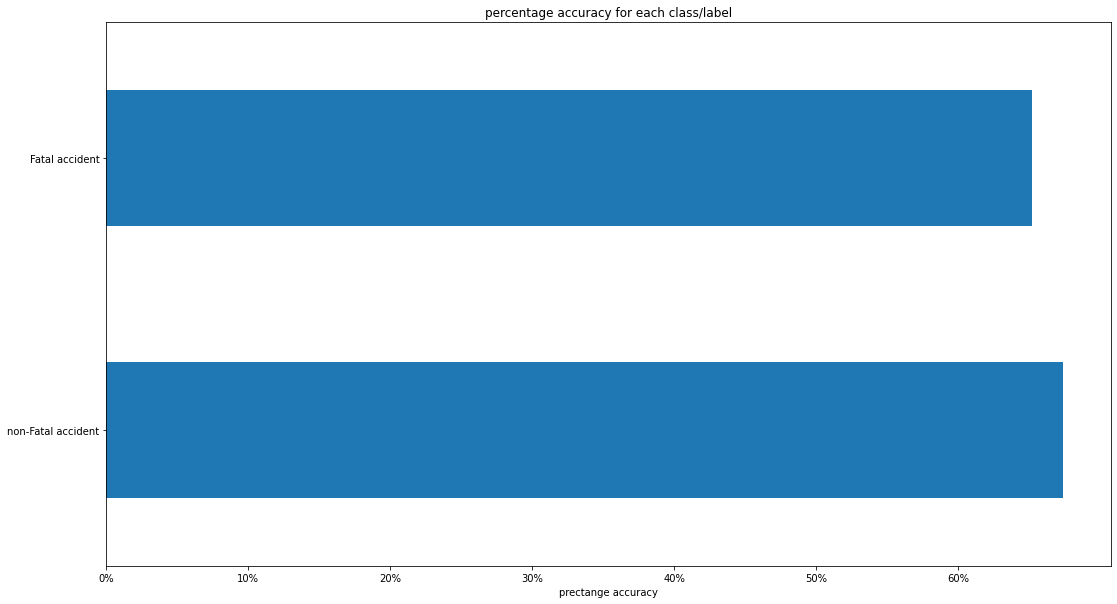

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 2 - 'weather_conditions', 'light_conditions','speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['weather_conditions', 'light_conditions','speed_limit','accident_severity']]

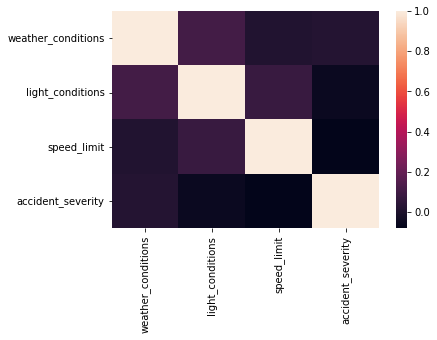

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

weather_conditions   -1.0
light_conditions     -1.0
speed_limit          -1.0
accident_severity     1.0
dtype: float64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['weather_conditions'][df_features['weather_conditions']==-1].count()

89

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['weather_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=0]
df_features = df_features[df_features['speed_limit']!=-1]
df_features = df_features[df_features['light_conditions']!=-1]

In [ ]:
df_features['speed_limit']

7128354    30.0
7128355    30.0
7128356    30.0
7128357    30.0
7128358    30.0
           ... 
8602819    30.0
8602820    30.0
8602821    60.0
8602822    30.0
8602823    30.0
Name: speed_limit, Length: 1474286, dtype: float64

In [ ]:
#bucketising weather condtion into 2 bins
df_features['weather_conditions'] = df_features['weather_conditions'].replace(1,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(4,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(5,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(7,0)
df_features['weather_conditions']= df_features['weather_conditions'].replace(2,1)
df_features['weather_conditions']= df_features['weather_conditions'].replace(3,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(6,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(8,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(9,1)
#bucketising light condtion into 2 bins
df_features['light_conditions'] = df_features['light_conditions'].replace(1,0)
df_features['light_conditions'] = df_features['light_conditions'].replace(7,0)
df_features['light_conditions'] = df_features['light_conditions'].replace(4,0)
df_features['light_conditions'] = df_features['light_conditions'].replace(5,1)
df_features['light_conditions'] = df_features['light_conditions'].replace(6,1)

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1225492
2     230660
1      18134
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18134
class 0 (non-fatal): 1456152


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18134
class 0 (non-fatal): 18134


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='weather_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='light_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdarz5ys5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdarz5ys5/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.1688101, step = 0
INFO:tensorflow:global_step/sec: 244.663
INFO:tensorflow:loss = 0.68105775, step = 100 (0.417 sec)
INFO:tensorflow:global_step/sec: 304.461
INFO:tensorflow:loss = 0.68383557, step = 200 (0.325 sec)
INFO:tensorflow:global_step/sec: 331.853
INFO:tensorflow:loss = 0.6823104, step = 300 (0.302 sec)
INFO:tensorflow:global_step/sec: 350.725
INFO:tensorflow:loss = 0.6862741, step = 400 (0.285 sec)
INFO:tensorflow:global_step/sec: 298.355
INFO:tensorflow:loss = 0.67859375, step = 500 (0.335 sec)
INF

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T15:22:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdarz5ys5/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.73545s
INFO:tensorflow:Finished evaluation at 2022-04-08-15:22:20
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.6647182, accuracy_baseline = 0.5040256, auc = 0.68672144, auc_precision_recall = 0.6821816, average_loss = 0.6575648, global_step = 5000, label/mean = 0.5040256, loss = 0.65727127, precision = 0.6682798, prediction/mean = 0.535775, recall = 0.66477025
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpdarz5ys5/model.ckpt-5000

Test set accuracy: 0.665



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdarz5ys5/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[-0.08195573],[0.47952253],"[0.5204775, 0.47952253]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
1,[-0.07469532],[0.48133487],"[0.51866513, 0.4813348]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
2,[-0.07469532],[0.48133487],"[0.51866513, 0.4813348]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
3,[-0.07469532],[0.48133487],"[0.51866513, 0.4813348]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
4,[0.048842132],[0.5122081],"[0.4877919, 0.5122081]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6647702407002188 
Accuracy of label 1 (fatal):  0.6646653324438515


Text(0.5, 1.0, 'percentage accuracy for each class/label')

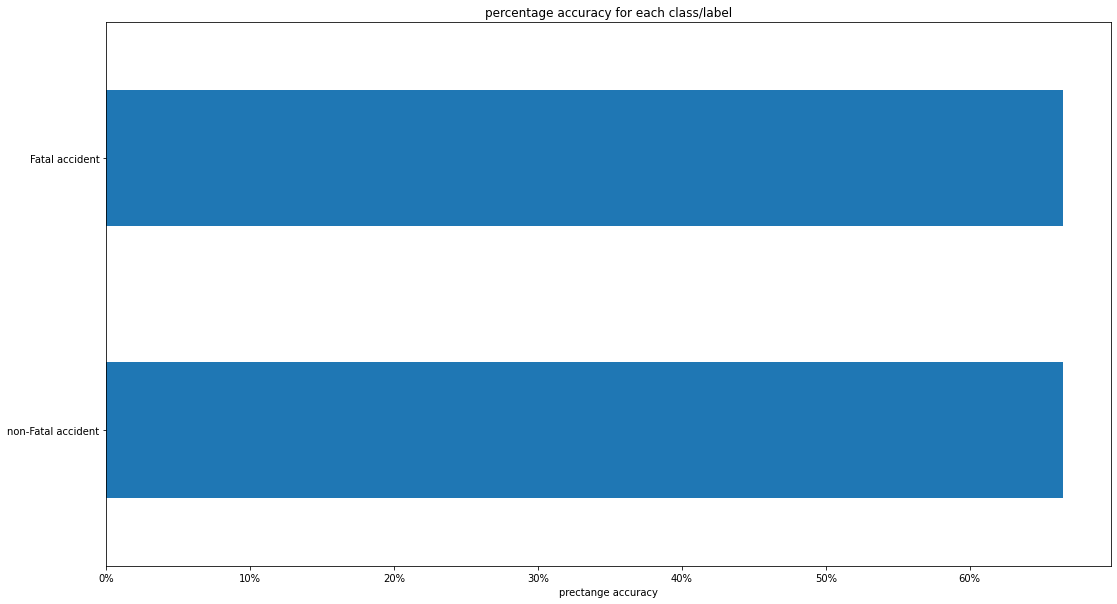

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

In [ ]:
a=df_predictions[df_predictions['actual label']==1]
print('actual class qty:',len(a))
a=a[a['predicted label']==0]
print('false neg:',len(a))

actual class qty: 4570
false neg: 1532


In [ ]:
a=df_predictions[df_predictions['predicted label']==1]
print('predicted class qty: ',len(a))
a=a[a['actual label']==0]
print('false pos:',len(a))

predicted class qty:  4546
false pos: 1508


#Iteration 3 - 'weather_conditions','speed_limit', 'road_surface_conditions'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['weather_conditions','speed_limit', 'road_surface_conditions','accident_severity']]

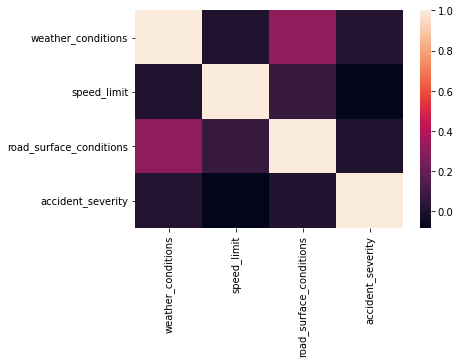

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

weather_conditions        -1.0
speed_limit               -1.0
road_surface_conditions   -1.0
accident_severity          1.0
dtype: float64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['weather_conditions'][df_features['weather_conditions']==-1].count()

89

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['weather_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=0]
df_features = df_features[df_features['road_surface_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=-1]

In [ ]:
#bucketising weather condtion into 2 bins
df_features['weather_conditions'] = df_features['weather_conditions'].replace(1,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(4,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(5,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(7,0)
df_features['weather_conditions']= df_features['weather_conditions'].replace(2,1)
df_features['weather_conditions']= df_features['weather_conditions'].replace(3,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(6,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(8,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(9,1)
#bucketising raod conditions into 3 bins
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(9,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(3,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(4,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(1,0)
df_features['road_surface_conditions']= df_features['road_surface_conditions'].replace(2,2)
df_features['road_surface_conditions']= df_features['road_surface_conditions'].replace(5,2)

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1222651
2     230352
1      18118
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18118
class 0 (non-fatal): 1453003


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18118
class 0 (non-fatal): 18118


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='weather_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='road_surface_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7v1fvg81', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7v1fvg81/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.69969565, step = 0
INFO:tensorflow:global_step/sec: 226.869
INFO:tensorflow:loss = 0.69432557, step = 100 (0.447 sec)
INFO:tensorflow:global_step/sec: 269.496
INFO:tensorflow:loss = 0.68939584, step = 200 (0.370 sec)
INFO:tensorflow:global_step/sec: 296.918
INFO:tensorflow:loss = 0.6840781, step = 300 (0.335 sec)
INFO:tensorflow:global_step/sec: 293.087
INFO:tensorflow:loss = 0.6772505, step = 400 (0.345 sec)
INFO:tensorflow:global_step/sec: 276.175
INFO:tensorflow:loss = 0.7002744, step = 500 (0.361 sec)
INF

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T14:46:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7v1fvg81/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.89634s
INFO:tensorflow:Finished evaluation at 2022-04-08-14:46:13
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.6549288, accuracy_baseline = 0.5001656, auc = 0.68178385, auc_precision_recall = 0.644542, average_loss = 0.6604279, global_step = 5000, label/mean = 0.5001656, loss = 0.6600173, precision = 0.64097935, prediction/mean = 0.5332264, recall = 0.70492166
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp7v1fvg81/model.ckpt-5000

Test set accuracy: 0.655



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7v1fvg81/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[0.08015597],[0.5200283],"[0.4799717, 0.52002823]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
1,[0.41925657],[0.60330534],"[0.39669463, 0.6033053]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
2,[-0.08939302],[0.47766662],"[0.5223334, 0.47766662]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
3,[-0.1502775],[0.46250117],"[0.53749883, 0.46250117]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
4,[0.5879892],[0.6429036],"[0.35709634, 0.6429036]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.704921650849702 
Accuracy of label 1 (fatal):  0.6049028268551236


Text(0.5, 1.0, 'percentage accuracy for each class/label')

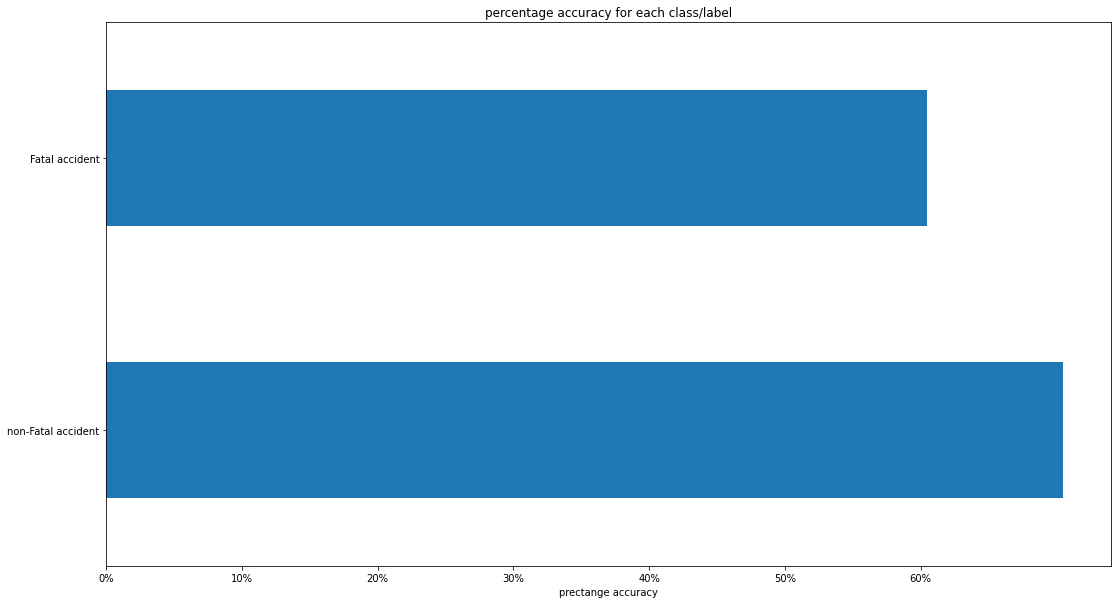

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 4 - 'weather_conditions'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['weather_conditions','accident_severity']]

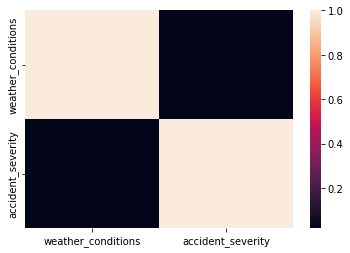

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

weather_conditions   -1
accident_severity     1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['weather_conditions'][df_features['weather_conditions']==-1].count()

89

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['weather_conditions']!=-1]
#df_features = df_features[df_features['speed_limit']!=0]

In [ ]:
#bucketising weather condtion into 2 bins
df_features['weather_conditions'] = df_features['weather_conditions'].replace(1,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(4,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(5,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(7,0)
df_features['weather_conditions']= df_features['weather_conditions'].replace(2,1)
df_features['weather_conditions']= df_features['weather_conditions'].replace(3,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(6,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(8,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(9,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1225579
2     230668
1      18134
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18134
class 0 (non-fatal): 1456247


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18134
class 0 (non-fatal): 18134


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='weather_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp77qik2_t', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp77qik2_t/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.69393, step = 0
INFO:tensorflow:global_step/sec: 297.467
INFO:tensorflow:loss = 0.69650084, step = 100 (0.342 sec)
INFO:tensorflow:global_step/sec: 388.076
INFO:tensorflow:loss = 0.6956068, step = 200 (0.257 sec)
INFO:tensorflow:global_step/sec: 460.217
INFO:tensorflow:loss = 0.69427127, step = 300 (0.218 sec)
INFO:tensorflow:global_step/sec: 454.004
INFO:tensorflow:loss = 0.6958731, step = 400 (0.220 sec)
INFO:tensorflow:global_step/sec: 427.547
INFO:tensorflow:loss = 0.6946303, step = 500 (0.234 sec)
INFO:t

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T13:44:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp77qik2_t/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.69508s
INFO:tensorflow:Finished evaluation at 2022-04-08-13:44:12
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.5195765, accuracy_baseline = 0.50104773, auc = 0.5203079, auc_precision_recall = 0.51008815, average_loss = 0.69239616, global_step = 5000, label/mean = 0.49895224, loss = 0.692373, precision = 0.51091194, prediction/mean = 0.49741647, recall = 0.86936337
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp77qik2_t/model.ckpt-5000

Test set accuracy: 0.520



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp77qik2_t/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[0.0026190854],[0.50065476],"[0.4993452, 0.50065476]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
1,[0.0026190854],[0.50065476],"[0.4993452, 0.50065476]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
2,[-0.083217084],[0.47920772],"[0.5207923, 0.47920775]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
3,[-0.083217084],[0.47920772],"[0.5207923, 0.47920775]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
4,[0.0026190854],[0.50065476],"[0.4993452, 0.50065476]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.8657274928461369 
Accuracy of label 1 (fatal):  0.17197170645446508


Text(0.5, 1.0, 'percentage accuracy for each class/label')

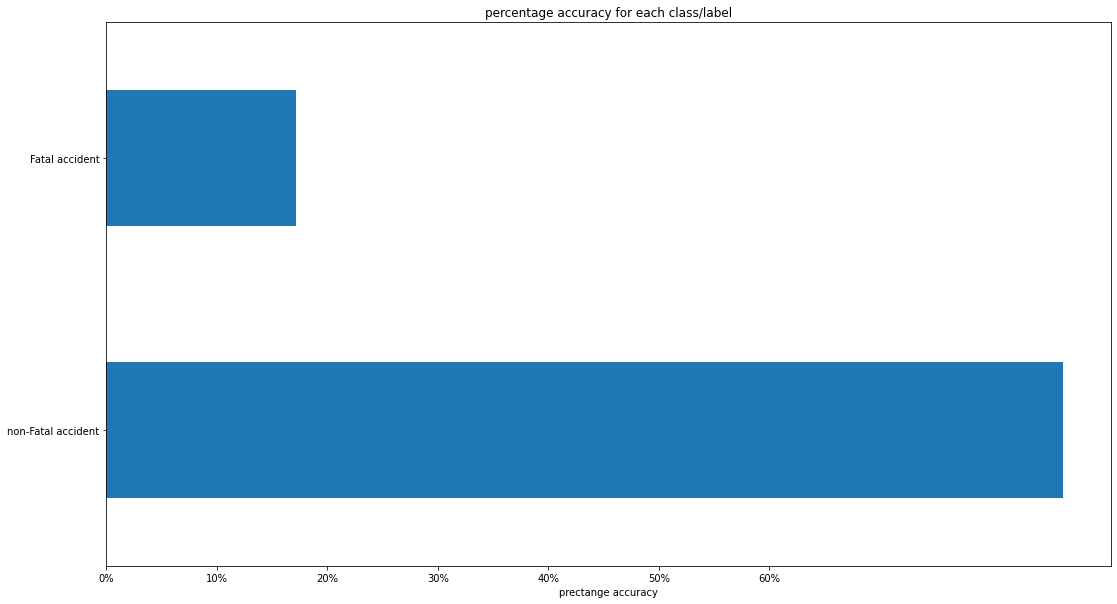

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 5  - 'weather_conditions','speed_limit', 'road_surface_conditions', light

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['weather_conditions','speed_limit', 'road_surface_conditions','light_conditions','accident_severity']]

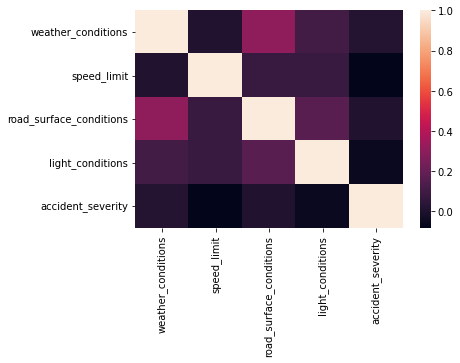

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

weather_conditions        -1.0
speed_limit               -1.0
road_surface_conditions   -1.0
light_conditions          -1.0
accident_severity          1.0
dtype: float64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['weather_conditions'][df_features['weather_conditions']==-1].count()

89

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['weather_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=0]
df_features = df_features[df_features['road_surface_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=-1]
df_features = df_features[df_features['light_conditions']!=-1]

In [ ]:
#bucketising weather condtion into 2 bins
df_features['weather_conditions'] = df_features['weather_conditions'].replace(1,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(4,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(5,0)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(7,0)
df_features['weather_conditions']= df_features['weather_conditions'].replace(2,1)
df_features['weather_conditions']= df_features['weather_conditions'].replace(3,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(6,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(8,1)
df_features['weather_conditions'] = df_features['weather_conditions'].replace(9,1)
#bucketising raod conditions into 3 bins
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(9,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(3,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(4,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(1,0)
df_features['road_surface_conditions']= df_features['road_surface_conditions'].replace(2,2)
df_features['road_surface_conditions']= df_features['road_surface_conditions'].replace(5,2)
#bucketising light condtion into 2 bins
df_features['light_conditions'] = df_features['light_conditions'].replace(1,0)
df_features['light_conditions'] = df_features['light_conditions'].replace(7,0)
df_features['light_conditions'] = df_features['light_conditions'].replace(4,0)
df_features['light_conditions'] = df_features['light_conditions'].replace(5,1)
df_features['light_conditions'] = df_features['light_conditions'].replace(6,1)

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1222650
2     230352
1      18118
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18118
class 0 (non-fatal): 1453002


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18118
class 0 (non-fatal): 18118


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='weather_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='road_surface_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='light_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp__i8au08', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp__i8au08/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.77233833, step = 0
INFO:tensorflow:global_step/sec: 221.294
INFO:tensorflow:loss = 0.75547415, step = 100 (0.454 sec)
INFO:tensorflow:global_step/sec: 259.013
INFO:tensorflow:loss = 0.72239834, step = 200 (0.389 sec)
INFO:tensorflow:global_step/sec: 267.972
INFO:tensorflow:loss = 0.71983206, step = 300 (0.376 sec)
INFO:tensorflow:global_step/sec: 257.448
INFO:tensorflow:loss = 0.7275338, step = 400 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.202
INFO:tensorflow:loss = 0.71819174, step = 500 (0.388 sec)
I

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T15:37:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp__i8au08/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 2.08164s
INFO:tensorflow:Finished evaluation at 2022-04-08-15:37:20
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.6468705, accuracy_baseline = 0.5025941, auc = 0.6780145, auc_precision_recall = 0.6452011, average_loss = 0.66028553, global_step = 5000, label/mean = 0.4974059, loss = 0.6599911, precision = 0.6316744, prediction/mean = 0.5324506, recall = 0.69573903
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp__i8au08/model.ckpt-5000

Test set accuracy: 0.647



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp__i8au08/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[-0.13471857],[0.4663712],"[0.53362876, 0.46637118]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
1,[0.92226034],[0.71550244],"[0.28449756, 0.71550244]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
2,[0.14870963],[0.537109],"[0.46289098, 0.5371091]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
3,[-0.13471857],[0.4663712],"[0.53362876, 0.46637118]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
4,[0.58683544],[0.6426387],"[0.3573613, 0.64263874]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6885569953876565 
Accuracy of label 1 (fatal):  0.6047492232578784


Text(0.5, 1.0, 'percentage accuracy for each class/label')

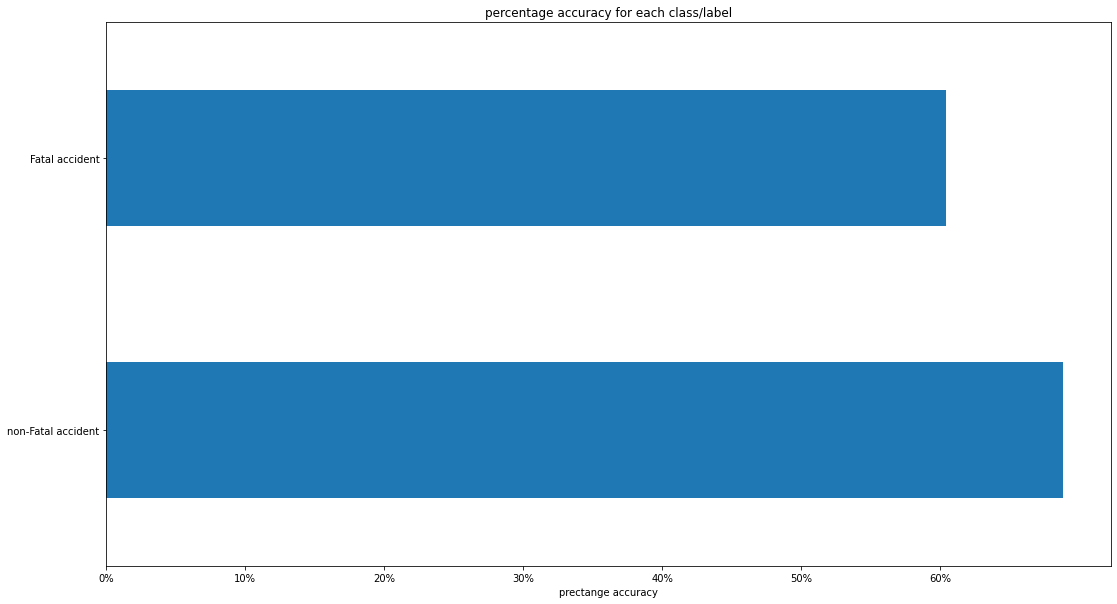

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

In [ ]:
a=df_predictions[df_predictions['actual label']==1]
print('actual class qty:',len(a))
a=a[a['predicted label']==0]
print('false neg:',len(a))

a=df_predictions[df_predictions['actual label']==1]
a=a[a['predicted label']==1]
print('true pos:',len(a))

actual class qty: 4506
false neg: 1371
true pos: 3135


In [ ]:
a=df_predictions[df_predictions['predicted label']==1]
print('predicted class qty: ',len(a))
a=a[a['actual label']==0]
print('false pos:',len(a))

predicted class qty:  4963
false pos: 1828


#Iteration 6 - 'speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['speed_limit','accident_severity']]

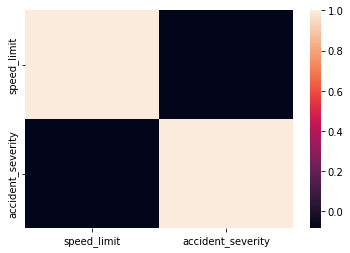

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

speed_limit         -1.0
accident_severity    1.0
dtype: float64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
#df_features['weather_conditions'][df_features['weather_conditions']==-1].count()

In [ ]:
#removing all rows with (missing) data
#df_features = df_features[df_features['weather_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=0]
df_features = df_features[df_features['speed_limit']!=-1]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1225574
2     230665
1      18138
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18138
class 0 (non-fatal): 1456239


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18138
class 0 (non-fatal): 18138


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7gb8kwcs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=10000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7gb8kwcs/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.9115522, step = 0
INFO:tensorflow:global_step/sec: 312.747
INFO:tensorflow:loss = 0.69143826, step = 100 (0.322 sec)
INFO:tensorflow:global_step/sec: 387.914
INFO:tensorflow:loss = 0.6936507, step = 200 (0.261 sec)
INFO:tensorflow:global_step/sec: 343.127
INFO:tensorflow:loss = 0.68013597, step = 300 (0.288 sec)
INFO:tensorflow:global_step/sec: 393.276
INFO:tensorflow:loss = 0.6846656, step = 400 (0.257 sec)
INFO:tensorflow:global_step/sec: 464.09
INFO:tensorflow:loss = 0.6821859, step = 500 (0.215 sec)
INFO:

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T14:06:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7gb8kwcs/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.72609s
INFO:tensorflow:Finished evaluation at 2022-04-08-14:06:08
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.65266293, accuracy_baseline = 0.5006065, auc = 0.66340894, auc_precision_recall = 0.63127637, average_loss = 0.6672481, global_step = 10000, label/mean = 0.5006065, loss = 0.66691446, precision = 0.65625, prediction/mean = 0.540932, recall = 0.64295155
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmp7gb8kwcs/model.ckpt-10000

Test set accuracy: 0.653



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7gb8kwcs/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6607929515418502 
Accuracy of label 1 (fatal):  0.6445131375579598


Text(0.5, 1.0, 'percentage accuracy for each class/label')

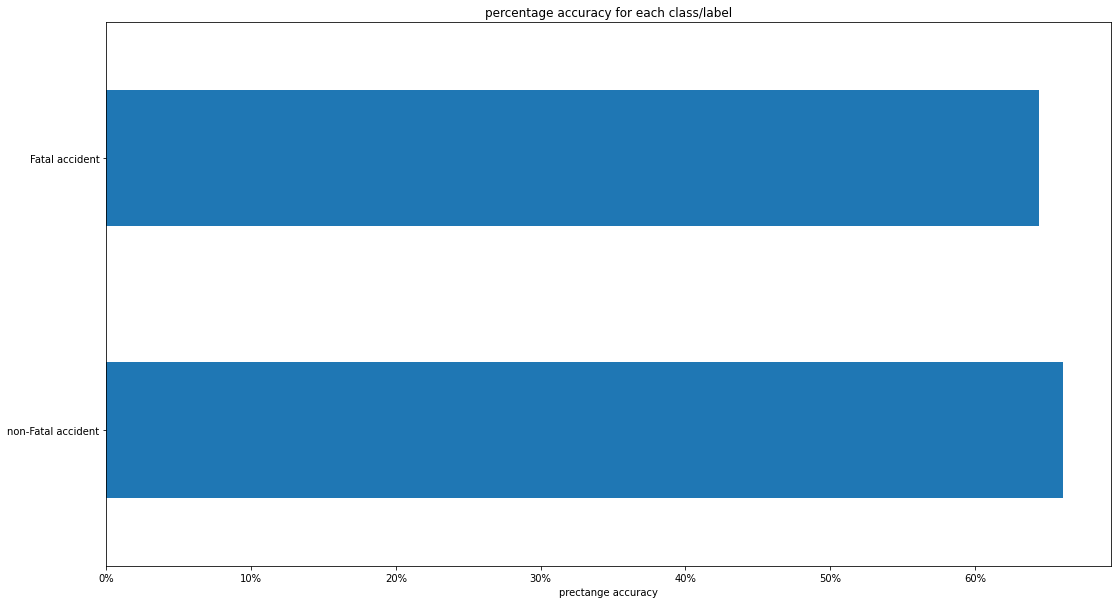

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 7 - 'speed_limit', 'road_surface_conditions'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['speed_limit', 'road_surface_conditions','accident_severity']]

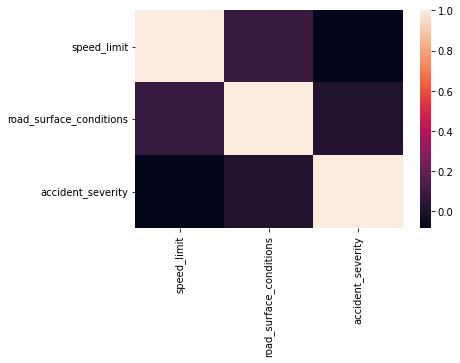

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

speed_limit               -1.0
road_surface_conditions   -1.0
accident_severity          1.0
dtype: float64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
#df_features['weather_conditions'][df_features['weather_conditions']==-1].count()

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['road_surface_conditions']!=-1]
df_features = df_features[df_features['speed_limit']!=0]
df_features = df_features[df_features['speed_limit']!=-1]

df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(9,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(3,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(4,0)
df_features['road_surface_conditions'] = df_features['road_surface_conditions'].replace(1,0)
df_features['road_surface_conditions']= df_features['road_surface_conditions'].replace(2,2)
df_features['road_surface_conditions']= df_features['road_surface_conditions'].replace(5,2)

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['accident_severity'].value_counts()

3    1222701
2     230356
1      18119
Name: accident_severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['accident_severity'] = df_features['accident_severity'].replace(2,0)
df_features['accident_severity'] = df_features['accident_severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['accident_severity'] == 1]
class_0 = df_features[df_features['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18119
class 0 (non-fatal): 1453057


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['accident_severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['accident_severity'] == 1]
class_0 = df_features_under[df_features_under['accident_severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 18119
class 0 (non-fatal): 18119


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('accident_severity')
test_label_under = test_features_under.pop('accident_severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='road_surface_conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbgxr_qzl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=2000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbgxr_qzl/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.7071343, step = 0
INFO:tensorflow:global_step/sec: 239.11
INFO:tensorflow:loss = 0.68440235, step = 100 (0.421 sec)
INFO:tensorflow:global_step/sec: 317.963
INFO:tensorflow:loss = 0.69962114, step = 200 (0.321 sec)
INFO:tensorflow:global_step/sec: 303.198
INFO:tensorflow:loss = 0.68094504, step = 300 (0.324 sec)
INFO:tensorflow:global_step/sec: 321.775
INFO:tensorflow:loss = 0.70301944, step = 400 (0.313 sec)
INFO:tensorflow:global_step/sec: 335.325
INFO:tensorflow:loss = 0.6929334, step = 500 (0.297 sec)
INF

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-08T14:56:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbgxr_qzl/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.89138s
INFO:tensorflow:Finished evaluation at 2022-04-08-14:56:48
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.5296909, accuracy_baseline = 0.502649, auc = 0.60669506, auc_precision_recall = 0.6162578, average_loss = 0.6774239, global_step = 2000, label/mean = 0.502649, loss = 0.6770207, precision = 0.5197573, prediction/mean = 0.53902894, recall = 0.846289
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpbgxr_qzl/model.ckpt-2000

Test set accuracy: 0.530



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbgxr_qzl/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[0.1337536],[0.5333886],"[0.46661133, 0.5333886]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
1,[0.1337536],[0.5333886],"[0.46661133, 0.5333886]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
2,[0.49256584],[0.6207107],"[0.3792893, 0.6207107]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
3,[0.1337536],[0.5333886],"[0.46661133, 0.5333886]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
4,[0.1337536],[0.5333886],"[0.46661133, 0.5333886]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.8462889767237594 
Accuracy of label 1 (fatal):  0.2097203728362184


Text(0.5, 1.0, 'percentage accuracy for each class/label')

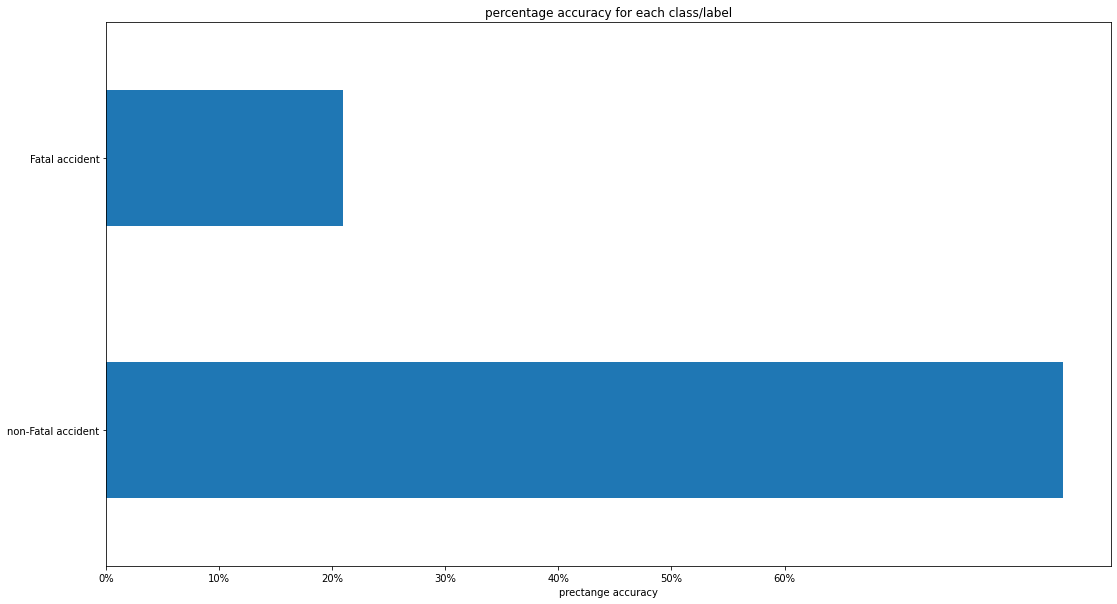

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')